# Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# Preparing Weather Data

In [2]:
weather=pd.read_csv("../MCI_30_Corrected.csv")
weather['DATE']= pd.to_datetime(weather['DATE'])
weather.set_index(["DATE"],inplace=True)
weather = weather.loc['2000-01-04':'2022-12-26']

In [3]:
weather

,AWND,PRCP,SNOW,SNWD,TMAX,TMIN
DATE,,,,,,
2000-01-04,12.53,0.0,0.0,0.0,28,13
2000-01-05,13.87,0.0,0.0,0.0,46,13
2000-01-06,7.61,0.0,0.0,0.0,45,27
2000-01-07,10.51,0.0,0.0,0.0,50,20
2000-01-08,10.96,0.0,0.0,0.0,49,32
...,...,...,...,...,...,...
2022-12-22,19.01,0.1,1.1,0.0,26,-4
2022-12-23,16.33,0.0,0.0,1.2,11,-4
2022-12-24,10.51,0.0,0.0,1.2,20,5


# Preparing Drought Categories

In [4]:
DM=pd.read_csv("../dm_Full.csv")
df_reverse_rows = DM.iloc[::-1]
test=df_reverse_rows.reset_index(drop=True)
test['Drought_Level'] = test[["None","D0","D1","D2","D3","D4"]].idxmax(axis=1)

In [5]:
test2=test[["ValidStart","Drought_Level"]].copy()
test2['ValidStart'] = pd.to_datetime(test2.ValidStart)
#test2['ValidStart'] = pd.to_datetime(test2.ValidStart, format='%Y/%m/%d')   
test2.set_index("ValidStart",inplace=True)

In [6]:
test3=test2.replace({'Drought_Level':{'None':0,'D0':1,'D1':2,'D2':3,'D3':4,'D4':5}})
test3

,Drought_Level
ValidStart,
2000-01-04,1
2000-01-11,1
2000-01-18,2
2000-01-25,2
2000-02-01,2
...,...
2022-11-22,2
2022-11-29,2
2022-12-06,2


# Merging Data Sets

In [7]:
a=weather.merge(test3, how='outer',left_index=True, right_index=True)
a.ffill(inplace=True)
a

,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,Drought_Level
2000-01-04,12.53,0.0,0.0,0.0,28,13,1.0
2000-01-05,13.87,0.0,0.0,0.0,46,13,1.0
2000-01-06,7.61,0.0,0.0,0.0,45,27,1.0
2000-01-07,10.51,0.0,0.0,0.0,50,20,1.0
2000-01-08,10.96,0.0,0.0,0.0,49,32,1.0
...,...,...,...,...,...,...,...
2022-12-22,19.01,0.1,1.1,0.0,26,-4,2.0
2022-12-23,16.33,0.0,0.0,1.2,11,-4,2.0
2022-12-24,10.51,0.0,0.0,1.2,20,5,2.0
2022-12-25,9.17,0.0,0.0,1.2,28,0,2.0


In [8]:
#a.to_csv('daily_DMC.csv')

# EDA

In [9]:
a.describe()

,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,Drought_Level
count,8393.000000,8393.000000,8393.000000,8393.000000,8393.000000,8393.000000,8393.000000
mean,10.118985,0.106876,0.048135,0.161122,65.623019,45.249970,0.693078
std,3.719146,0.340639,0.402153,0.831661,20.505176,19.471049,1.087200
min,2.010000,0.000000,0.000000,0.000000,-1.000000,-13.000000,0.000000
25%,7.380000,0.000000,0.000000,0.000000,50.000000,30.000000,0.000000
50%,9.620000,0.000000,0.000000,0.000000,69.000000,47.000000,0.000000
75%,12.300000,0.010000,0.000000,0.000000,83.000000,63.000000,1.000000
max,27.290000,4.480000,9.200000,10.000000,107.000000,82.000000,5.000000


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

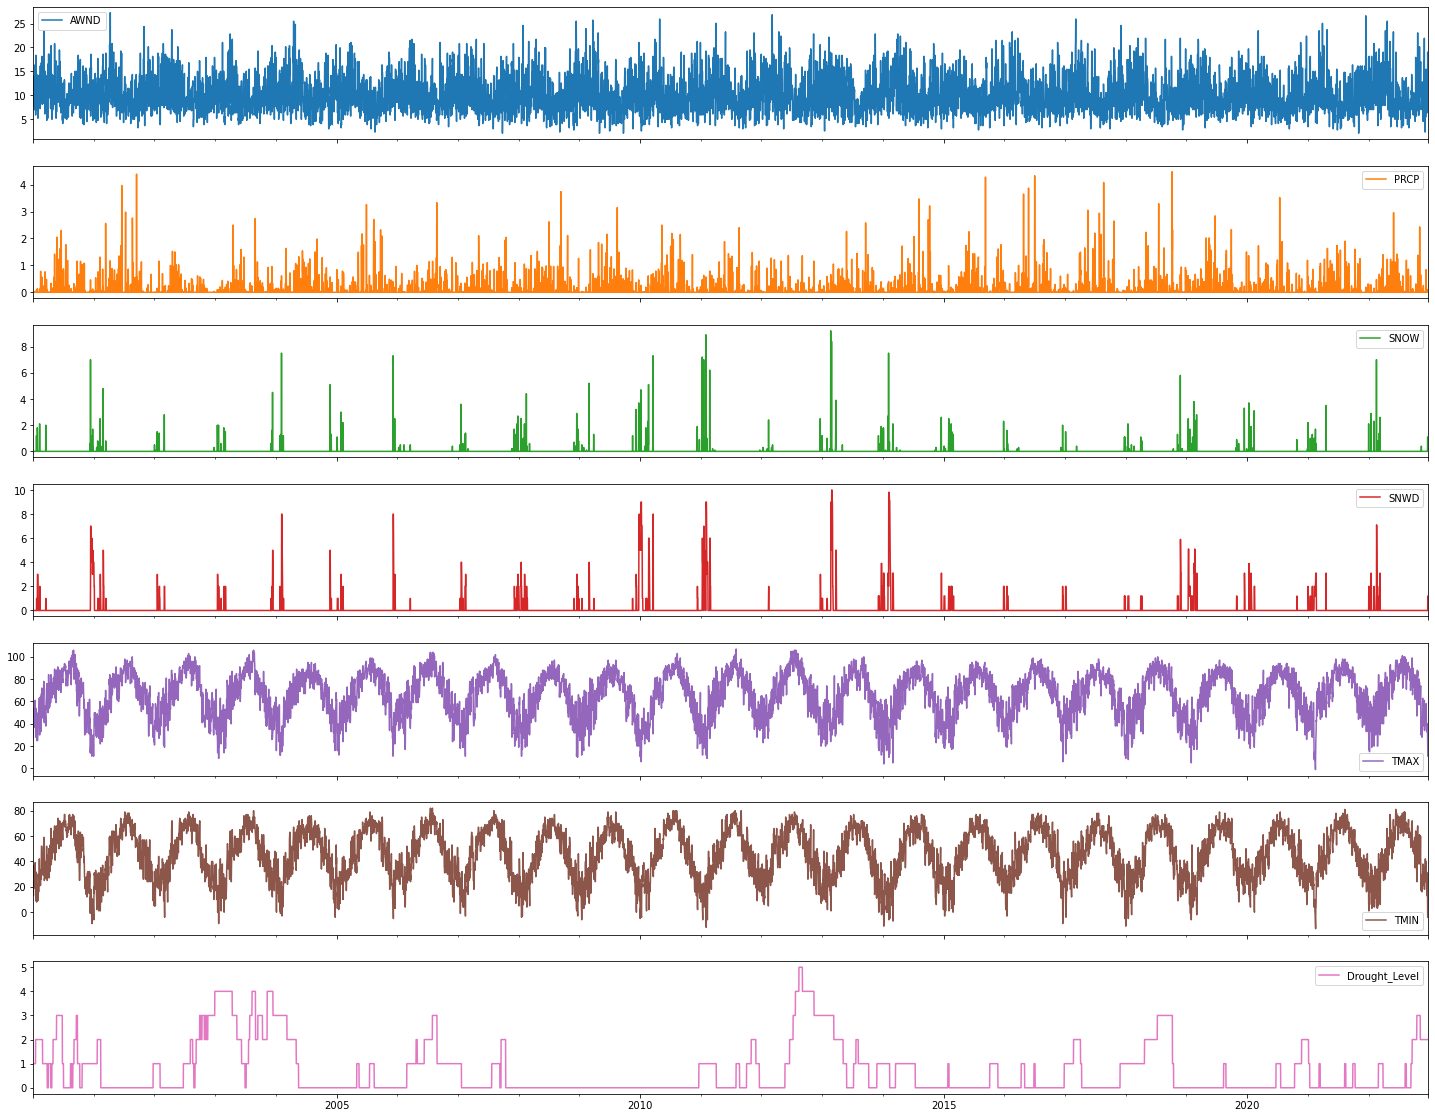

In [10]:
a.plot(subplots=True, figsize=(25,20))

array([[<AxesSubplot:title={'center':'AWND'}>,
        <AxesSubplot:title={'center':'PRCP'}>,
        <AxesSubplot:title={'center':'SNOW'}>],
       [<AxesSubplot:title={'center':'SNWD'}>,
        <AxesSubplot:title={'center':'TMAX'}>,
        <AxesSubplot:title={'center':'TMIN'}>],
       [<AxesSubplot:title={'center':'Drought_Level'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

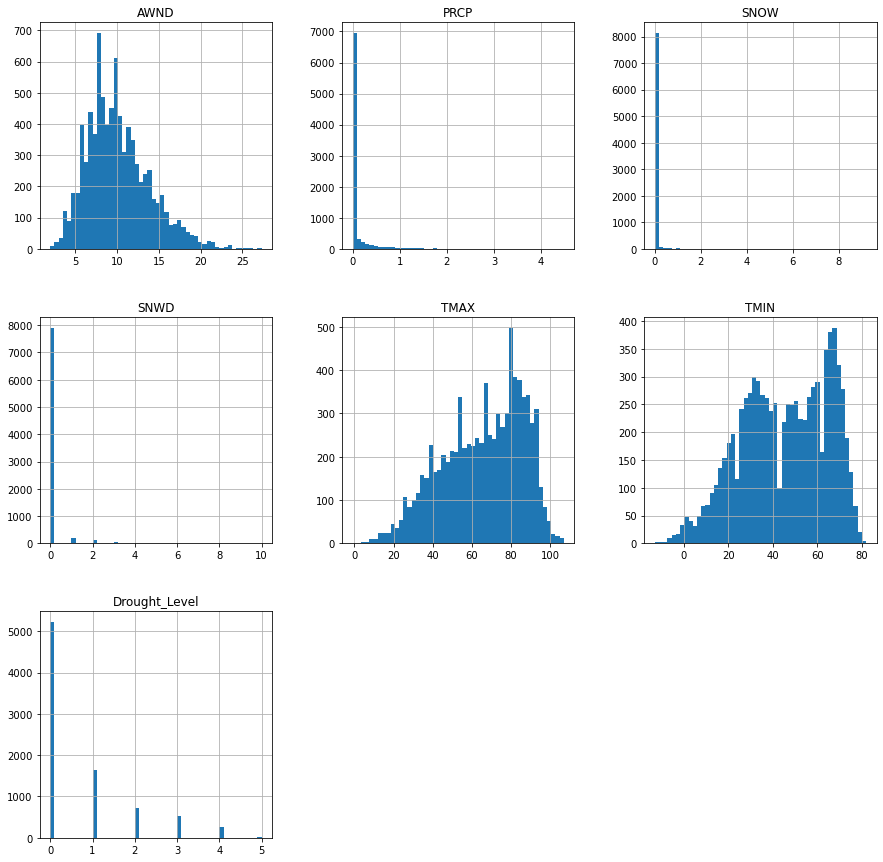

In [11]:
a.hist(bins=50,figsize=(15,15))

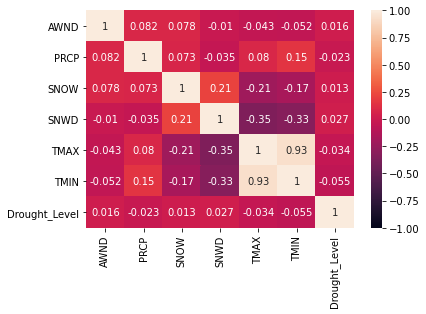

In [12]:
heatmap = sns.heatmap(a.corr(), vmin=-1, vmax=1, annot=True)

# Feature Selection

In [13]:
y=a[["Drought_Level"]].values
x=a[["AWND","PRCP","SNOW","SNWD","TMAX","TMIN"]].values

In [14]:
y=a.pop("Drought_Level")
x=a

In [15]:
train_X,test_X,train_Y,test_Y=train_test_split(x,y,test_size=0.25,shuffle=False)

In [16]:
train_X_norm=preprocessing.normalize(train_X)
test_X_norm=preprocessing.normalize(test_X)

# Decision Trees

In [17]:
model_1= DecisionTreeClassifier()
model_1.fit(train_X,train_Y)

DecisionTreeClassifier()

In [18]:
sfs1 = SFS(model_1, 
           k_features="best",
           forward=True, 
           floating=False, 
           verbose=0,
           scoring='accuracy',
           cv=10)

sfs1 = sfs1.fit(train_X, train_Y)

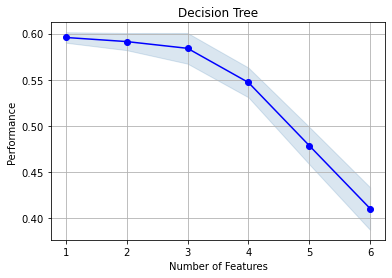

In [19]:
metric_dict1 = sfs1.get_metric_dict(confidence_interval=0.95)
fig1 = plot_sfs(metric_dict1, kind='std_dev')
plt.title('Decision Tree')
plt.grid()
plt.show()

In [20]:
print('Best subset:', sfs1.k_feature_idx_)
print('Best subset (corresponding names):', x.columns[:][list(sfs1.k_feature_idx_)])

Best subset: (5,)
Best subset (corresponding names): Index(['TMIN'], dtype='object')


# Random Forest

In [21]:
model_2= RandomForestClassifier()
model_2.fit(train_X,train_Y)

RandomForestClassifier()

In [22]:
sfs2 = SFS(model_2, 
           k_features="best",
           forward=True, 
           floating=False, 
           verbose=0,
           scoring='accuracy',
           cv=10)

sfs2 = sfs2.fit(train_X, train_Y)

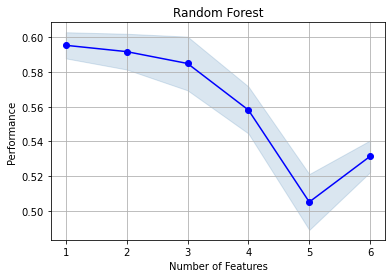

In [23]:
metric_dict2 = sfs2.get_metric_dict(confidence_interval=0.95)
fig1 = plot_sfs(metric_dict2, kind='std_dev')
plt.title('Random Forest')
plt.grid()
plt.show()

In [24]:
print('Best subset:', sfs2.k_feature_idx_)
print('Best subset (corresponding names):', x.columns[:][list(sfs2.k_feature_idx_)])

Best subset: (3,)
Best subset (corresponding names): Index(['SNWD'], dtype='object')


# Logistic Regression

In [25]:
model_3= LogisticRegression(max_iter=175)
model_3.fit(train_X_norm,train_Y)

LogisticRegression(max_iter=175)

In [26]:
sfs3 = SFS(model_3, 
           k_features="best",
           forward=True, 
           floating=False, 
           verbose=0,
           scoring='accuracy',
           cv=10)

sfs3 = sfs3.fit(train_X_norm, train_Y)

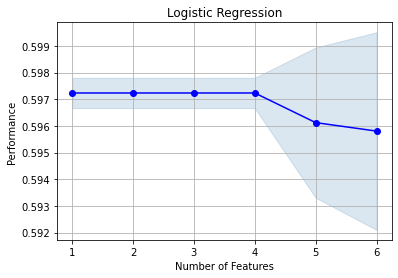

In [27]:
metric_dict3 = sfs3.get_metric_dict(confidence_interval=0.95)
fig1 = plot_sfs(metric_dict3, kind='std_dev')
plt.title('Logistic Regression')
plt.grid()
plt.show()

In [28]:
print('Best subset:', sfs3.k_feature_idx_)
print('Best subset (corresponding names):', x.columns[:][list(sfs3.k_feature_idx_)])

Best subset: (1,)
Best subset (corresponding names): Index(['PRCP'], dtype='object')


# k-Nearest Neighbors

In [29]:
model_4= KNeighborsClassifier(n_neighbors=17)
model_4.fit(train_X_norm,train_Y)

KNeighborsClassifier(n_neighbors=17)

In [30]:
sfs4 = SFS(model_4, 
           k_features="best",
           forward=True, 
           floating=False, 
           verbose=0,
           scoring='accuracy',
           cv=10)

sfs4 = sfs4.fit(train_X_norm, train_Y)

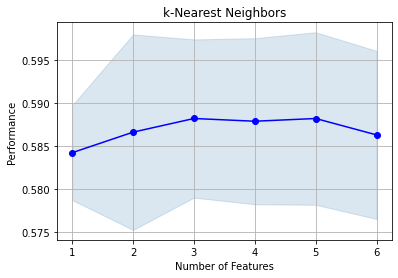

In [31]:
metric_dict4 = sfs4.get_metric_dict(confidence_interval=0.95)
fig1 = plot_sfs(metric_dict4, kind='std_dev')
plt.title('k-Nearest Neighbors')
plt.grid()
plt.show()

In [32]:
print('Best subset:', sfs4.k_feature_idx_)
print('Best subset (corresponding names):', x.columns[:][list(sfs4.k_feature_idx_)])

Best subset: (0, 3, 4)
Best subset (corresponding names): Index(['AWND', 'SNWD', 'TMAX'], dtype='object')
